In [16]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import poly1d
import statsmodels as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

mpl.style.use("seaborn-whitegrid")
mpl.rcParams['figure.figsize'] = (10,2)
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
font = {'family' : 'calibri',
        'size'   : 10}

mpl.rc('font', **font)

Prepare Data

            brent    wti  spread
timestamp                       
1990-01-03  21.69  23.68   -1.99
1990-01-04  21.51  23.41   -1.90
1990-01-05  22.00  23.08   -1.08
1990-01-08  20.52  21.62   -1.10
1990-01-09  20.14  22.07   -1.93
            brent    wti  spread
timestamp                       
2020-03-03  51.86  47.18    4.68
2020-03-04  51.13  46.78    4.35
2020-03-05  49.99  45.90    4.09
2020-03-06  45.27  41.28    3.99
2020-03-09  36.69  33.79    2.90


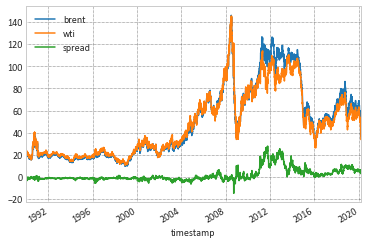

In [17]:
path = "https://github.com/queiyanglim/trading_algorithm/raw/master/oil_trading/data/oil_prices.csv"

df_pull = pd.read_csv(path, header=[0], index_col = 0)
df_pull = df_pull[["CO1 Comdty", "CL1 Comdty"]]
df_pull.index.name = "timestamp"
df_pull = df_pull.rename(columns = {"CO1 Comdty": "brent",
                                    "CL1 Comdty": "wti"})
df_pull.index = pd.to_datetime(df_pull.index, format = "%d/%m/%Y")
df = df_pull.copy()
df["spread"] = df.brent - df.wti
# df = df.tail(2000)
# df = np.log(df).diff()
df = df.dropna()
/print df.head()
/print df.tail()
df.plot()

In [90]:
# Check Rolling Cointegration
def rolling_coint(df_input,x_name,y_name, update_window):
    roll_p = []
    for i in range(len(df_input) - update_window + 1):
        df = df_input.iloc[i:i + update_window] # Fix window size
        # df = df_input.iloc[:i + update_window] # Update as it goes
        x = df[x_name]
        y = df[y_name]
        coint_res = coint(x.values, y.values)
        p_value = coint_res[1]
        roll_p.append({"timestamp": df.index[-1],
                      "p_value": p_value})
    return pd.DataFrame(roll_p).set_index("timestamp")
    
roll_coint = rolling_coint(df, "wti","brent",300)

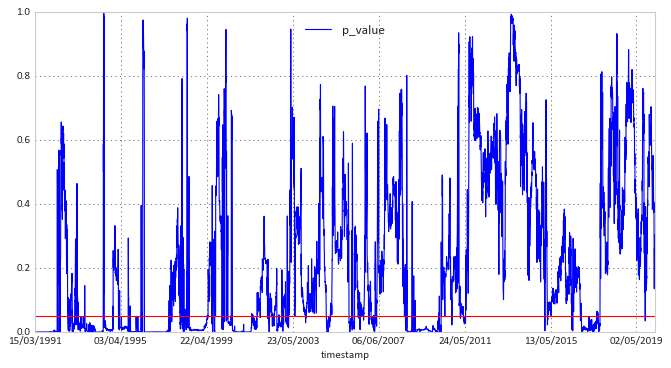

In [24]:
roll_coint.plot(figsize = (10,5))
plt.axhline(0.05, color = "red")

In [19]:
delta = 1e-5
trans_cov = delta / (1 - delta) *np.eye(2)
/print "transition_covriance:"
/print trans_cov

obs_mat = np.vstack([df.wti, np.ones(df.wti.shape)]).T[:,np.newaxis]
/print "observation_matrix"
/print obs_mat
/print df.wti
kf = KalmanFilter(n_dim_obs = 1,
                 n_dim_state = 2,
                 initial_state_mean=np.zeros(2),
                 initial_state_covariance=np.ones((2,2)),
                 transition_matrices = np.eye(2),
                 observation_matrices = obs_mat,
                 observation_covariance=1.0,
                 transition_covariance=trans_cov)

#state_means, state_covs = kf.smooth(df.brent.values)
state_means, state_covs = kf.filter(df.brent.values)

transition_covriance:
[[1.00001e-05 0.00000e+00]
 [0.00000e+00 1.00001e-05]]
observation_matrix
[[[23.68  1.  ]]

 [[23.41  1.  ]]

 [[23.08  1.  ]]

 ...

 [[45.9   1.  ]]

 [[41.28  1.  ]]

 [[33.79  1.  ]]]
timestamp
1990-01-03    23.68
1990-01-04    23.41
1990-01-05    23.08
1990-01-08    21.62
1990-01-09    22.07
              ...  
2020-03-03    47.18
2020-03-04    46.78
2020-03-05    45.90
2020-03-06    41.28
2020-03-09    33.79
Name: wti, Length: 7514, dtype: float64


Shape (7514, 2)


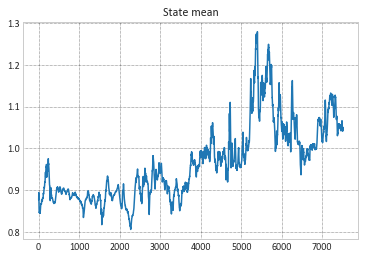

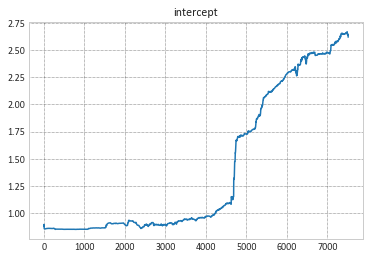

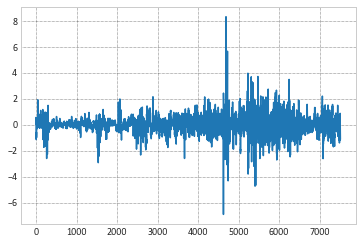

In [21]:
/print "Shape",state_means.shape
plt.plot(state_means[:,0])
plt.title("State mean")
plt.show()
plt.plot(state_means[:,1])
plt.title("intercept")
plt.show()
predict = state_means[:,0] * df.wti.values + state_means[:,1]
plt.plot(df.brent.values - predict)
plt.show()

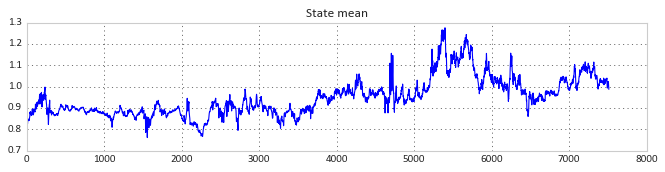

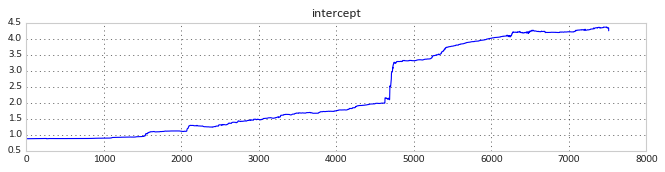

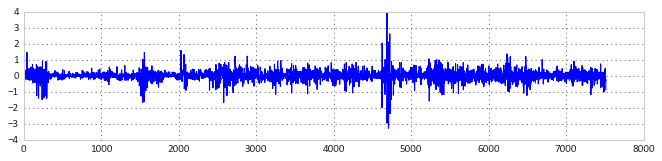

In [75]:
# Expectation Maximization
kf2 = kf.em(df.brent.values, n_iter = 5)
state_means_2, state_covs_2 = kf2.filter(df.brent.values)

state_means.shape
plt.plot(state_means_2[:,0])
plt.title("State mean")
plt.show()
plt.plot(state_means_2[:,1])
plt.title("intercept")
plt.show()
predict = state_means_2[:,0] * df.wti.values + state_means_2[:,1]
plt.plot(df.brent.values - predict)
plt.show()


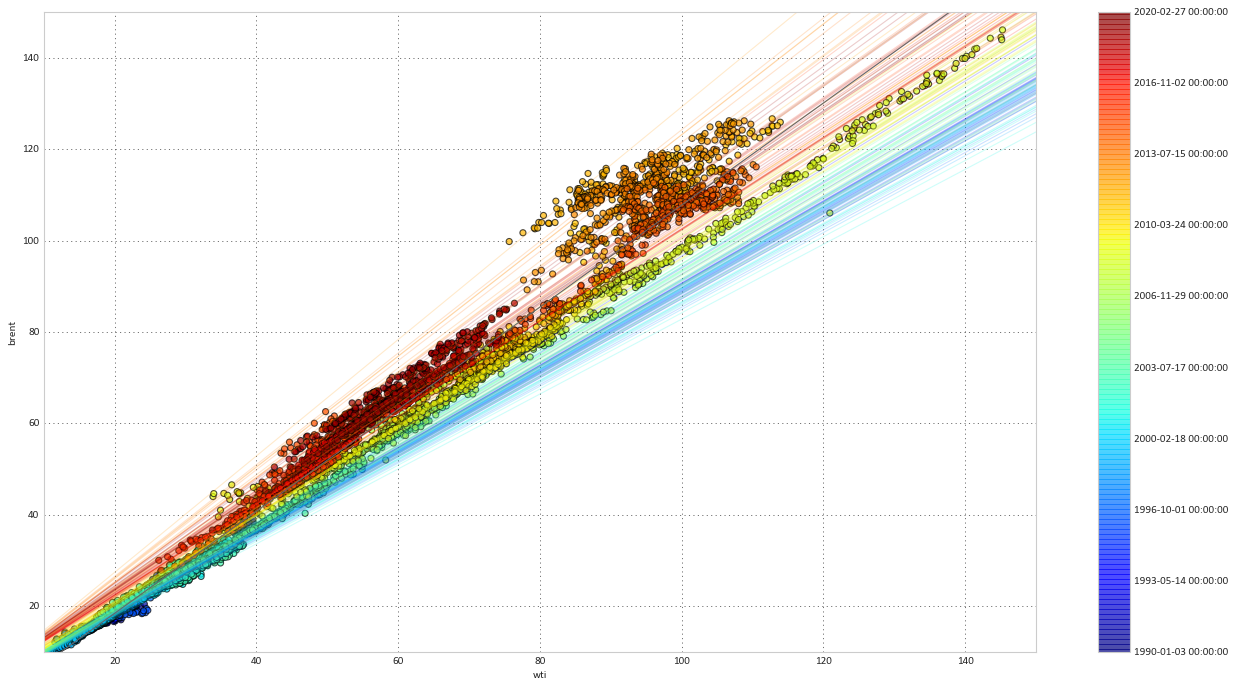

In [93]:
y = df.brent
x = df.wti

fig= plt.figure(figsize=(20,10))
# Plot data points using colormap
colors = np.linspace(0.1, 1, len(x))
cm = plt.get_cmap('jet')
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([p for p in x[::len(x)//9].index])

# Plot every fifth line
step = 50
xi = np.linspace(x.min()-5, x.max()+5, 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))
    
# Plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x, y, 1))(xi), '0.4')

# Adjust axes for visibility
plt.axis([10, 150, 10, 150])

# Label axes
plt.xlabel('wti')
plt.ylabel('brent');

In [109]:
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = add_constant(spread_lag)
    model = OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

def kalman_filter_regression(x, y):
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack([x, np.ones(x.shape)]).T[:,np.newaxis]
    kf = KalmanFilter(n_dim_obs=1, 
                        n_dim_state=2,
                        initial_state_mean=[0,0],
                        initial_state_covariance=np.ones((2, 2)),
                        transition_matrices=np.eye(2),
                        observation_matrices=obs_mat,
                        observation_covariance=2,
                        transition_covariance=trans_cov)
    kf2 = kf.em(y.values)
    # state_means, state_covs = kf.filter(y.values)
    state_means, state_covs = kf2.filter(y.values)
    return state_means

def kalman_filter_average(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)

  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

In [67]:
x = df.wti
x1 = kalman_filter_average(x)

/print x1
/print x

(array([[11.84      ],
       [15.74774834],
       [17.63962852],
       ...,
       [49.5446083 ],
       [48.75843808],
       [47.33456657]]), array([[[0.5       ]],

       [[0.33774834]],

       [[0.25802172]],

       ...,

       [[0.09512492]],

       [[0.09512492]],

       [[0.09512492]]]))
timestamp
03/01/1990    23.68
04/01/1990    23.41
05/01/1990    23.08
08/01/1990    21.62
09/01/1990    22.07
              ...  
03/03/2020    47.18
04/03/2020    46.78
05/03/2020    45.90
06/03/2020    41.28
09/03/2020    33.79
Name: wti, Length: 7514, dtype: float64


2

In [14]:
import numpy as np

delta = 1e-2
trans_cov = delta / (1 - delta) * np.eye(2)

trans_cov

array([[0.01010101, 0.        ],
       [0.        , 0.01010101]])

Sharpe:
1.9167083193191725


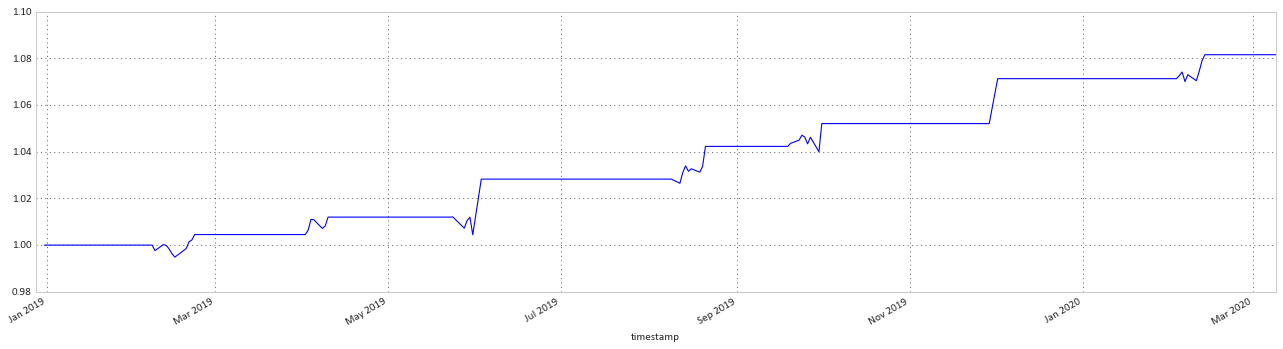

In [114]:
def backtest(df,s1, s2):
    #############################################################
    # INPUT:
    # DataFrame of prices
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two
    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: Sharpe ratio
    # CAGR: Compound Annual Growth Rate
    x, y = df[s1], df[s2]

    # run regression (including Kalman Filter) to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df.index)
    
    # Use Kalman Filter one single series to filter out "noise"
    # Fundamental assumption that noise of series is normally distributed
    state_means = kalman_filter_regression(kalman_filter_average(x),kalman_filter_average(y))
    # state_means = kalman_filter_regression(x,y)

    # Hedge ratio estimated from dynamic linear model
    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)

    # calculate half life
    # halflife = half_life(df1['spread'])
    # print("Halflife:", halflife)
    halflife = 20
    
    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    # trading logic
    entryZscore, exitZscore = 2, 0

    # if current z-score less than pre-defined entry's z-score and while previous day's zScore was
    # within the z-score band then enter long on the spread
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    
    # if current z-score trades back within band (> -z-score) and previous day was signalling underpriced spread
    # then exit the position
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'].iloc[0] = 0 

    df1['num units long'] = df1['num units long'].fillna(method='pad') 
    #set up num units short 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'].iloc[0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    ##############################################################
    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0
    ##############################################################
    start_val = 1
    end_val = df1['cum rets'].iat[-1]

    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name

    days = (end_date - start_date).days

    CAGR = round(((float(end_val) / float(start_val)) ** (252.0/days)) - 1,4)

    df1[s1+ " "+s2] = df1['cum rets']

    return df1, df1[s1+" "+s2], sharpe, CAGR

p, a,b,c = backtest(df.tail(300),"wti", "brent")
/print "Sharpe:"
/print b
p["cum rets"].plot(figsize = (20,5))

In [55]:
df_tmp = df.copy()